# Using the Facebook Prophet to predict sales

**The objective of this notebook is demonstrate a simple analysis using the Facebook Prophet to predict sales f champagne**

## Attemption!
If you are using the **jupyter notebook with Anaconda, you need install the fb.prophet**

**To install:**

   **with the notebook running**, type: *!pip install fbprophet*
    
   Or you can install **using the anaconda prompt**, type: *conda install -c conda-forge fbprophet*
        
## If you get this error when run the fbprophet:

**ImportError: cannot import name 'easter' from 'holidays'**
    
**Try this solution:**
    
 Replace line 16 in **fbprophet/hdays.py** (\anaconda3\Lib\site-packages\fbprophet\hdays.py) to:
        
        from holidays import WEEKEND, HolidayBase
        from dateutil.easter import easter
        from dateutil.relativedelta import relativedelta as rd
    

### To avoid this installation work, you can just you the google collab
**There you don't need to install the libary**

In [135]:
# Let's import some lybraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [138]:
# Let's import our csv file with the data
# Remeber: The csv file must be in the same place of your notebook

file = 'champagne_sales.csv'
df = pd.read_csv(file, parse_dates = True)

In [69]:
# We can see the first five rows in our dataset

df.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


In [140]:
# To see the dataframe info
# We got here 105 rows by 2 columns (features) without missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
Month    105 non-null object
Sales    105 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.8+ KB


In [70]:
# Some statistical information about the sales

df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


Text(0, 0.5, 'N° of Sales')

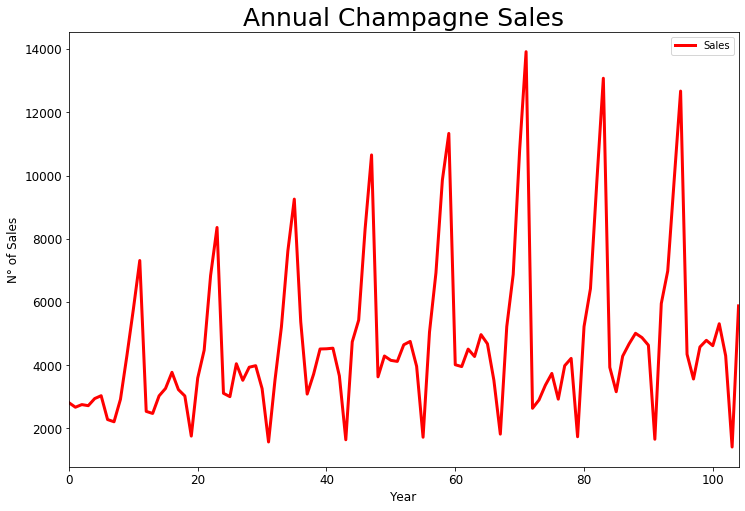

In [71]:
# We can plot a line graphic with the data to analyse some features of our data

df.plot(figsize = (12,8), linewidth = 3, fontsize = 12 , color = 'red')
plt.title('Annual Champagne Sales',fontsize = 25)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('N° of Sales', fontsize = 12)

In [ ]:
## We can see that our data has tendency - each year the sales increase - and a sasonality - repetitive behavior (look at the spikes)

**Remember: this is just a visual observation, to have a better analysis We need to see more than just this graphic!**

In [151]:
# Let's import our csv file again, but now using the parse_dates parameter that transform our Month feature in a datetime
# We need to use the 'squeeze' parameter as True to import our data as a pandas series

series = pd.read_csv(file, parse_dates =['Month'],index_col=0, squeeze=True)

In [155]:
# Look now the feature 'Month' is a datetime type
series.head()

Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Sales, dtype: int64

In [156]:
# Let's now separete 12 months to validate our model creating a split point to 'cut' our dataframe

split_point = len(series)-12

In [157]:
# Let's save into 'data' the values until or split point - all the original data less the last 12 months
data = series[:split_point]

In [158]:
# Here into 'validation' we'll save the last 12 months

validation = series[split_point:]

In [159]:
# We can print the number of rows that each variable has: 

print('The data dataset has {} rows and the validade dataset has {} rows'.format(len(data), len(validation)))

The data dataset has 93 rows and the validade dataset has 12 rows


## Preparing the data to our Prophet model

The fb Prophet only receive two features: **'ds' with the date values and 'y' with the target values**
    
To prepare our dataset to the model, we need to create a dataframe pandas with columns with the correctly name

In [160]:
# Here we just pass the data index and data values to our new dataframe

dataframe = pd.DataFrame({'ds':data.index, 'y':data.values})
dataframe.tail()

,ds,y
88,1971-05-01,5010
89,1971-06-01,4874
90,1971-07-01,4633
91,1971-08-01,1659
92,1971-09-01,5951


## Starting to teach the model!

In [161]:
# First, let's import the class 'Prophet' from the library 'fbprophet'

from fbprophet import Prophet

In [162]:
# Now we create our model using the parameter 'seasonality_mode' as 'multiplicative'
# This parameter is used when you have a sasonality that increases every year
# By the end, we fit the model with our dataframe (that doesn't have the last 12 months)

model = Prophet(seasonality_mode = 'multiplicative')
model.fit(dataframe)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [193]:
# The Prophet allow us to create a 'future' dataframe , that has just date values, to predict the sales values
# To make this, you need to set up the periods (in this case is 12) and frequency (in this case is Month ("M"))

future = model.make_future_dataframe(periods = 12, freq = 'M') #cria um novo dataframe

In [194]:
future.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 1 columns):
ds    105 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 968.0 bytes


In [195]:
future.head()

,ds
0,1964-01-01
1,1964-02-01
2,1964-03-01
3,1964-04-01
4,1964-05-01


## Making Predictions!

In [196]:
# Using the method '.predict', we just pass the 'future' dataframe to create some predictions

predictions = model.predict(future)

In [197]:
# As you can see, the predict returns a dataframe with 16 features

predictions.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yhat'],
      dtype='object')

In [198]:
# To a simple analysis, we will use only 4 features
# ds - date values
# yhat - Sale predicted value (mean)
# yhat_lower - the smaller value predicted
# yhat_upper - the highest value predicted

predictions[['ds','yhat','yhat_lower','yhat_upper']].tail(12) # Using '.tail(12)' We can see the last 12 rows

,ds,yhat,yhat_lower,yhat_upper
93,1971-09-30,5677.010992,4992.224449,6344.806012
94,1971-10-31,9502.184363,8857.685081,10197.510669
95,1971-11-30,13492.133479,12797.147202,14182.624145
96,1971-12-31,5813.930731,5176.169517,6459.433201
97,1972-01-31,4568.884979,3890.406859,5217.828854
98,1972-02-29,4185.990891,3512.664183,4845.515921
99,1972-03-31,4963.289832,4284.621178,5705.189883
100,1972-04-30,4851.378755,4156.155848,5556.287445
101,1972-05-31,5167.734245,4460.911811,5850.741436
102,1972-06-30,5020.255859,4294.593537,5699.951845


In [199]:
# To compare, let's see the last real values 

validation

Month
1971-10-01     6981
1971-11-01     9851
1971-12-01    12670
1972-01-01     4348
1972-02-01     3564
1972-03-01     4577
1972-04-01     4788
1972-05-01     4618
1972-06-01     5312
1972-07-01     4298
1972-08-01     1413
1972-09-01     5877
Name: Sales, dtype: int64

**The values created by our future dataframe is far away from the original data**

**But, as you can see in the graphic below, the shape of our future data is basead in the original shape**

Text(47.5, 0.5, 'N° of Sales')

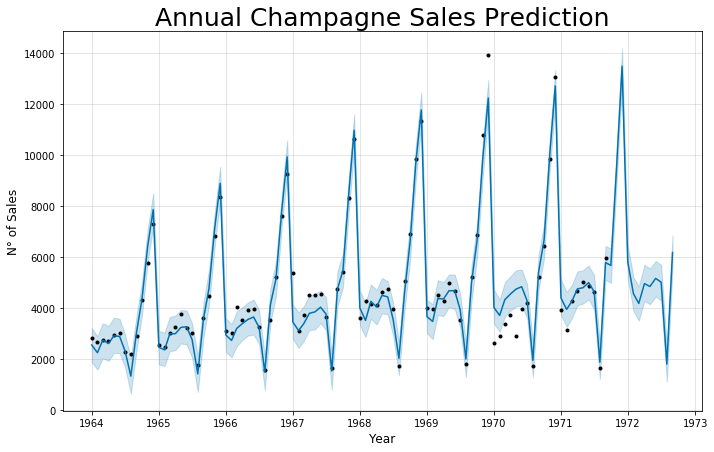

In [200]:
# Let's plot the future predictions

fig = model.plot(predictions)
plt.title('Annual Champagne Sales Prediction',fontsize = 25)
plt.xlabel('Year', fontsize = 12)
plt.ylabel('N° of Sales', fontsize = 12)

## Let's predict with the real data!

In [184]:
# First, let's create a dataframe with the validation index, just the dates, with the column name correctly

validation_df = pd.DataFrame({'ds':validation.index})

In [185]:
validation_df.head()

,ds
0,1971-10-01
1,1971-11-01
2,1971-12-01
3,1972-01-01
4,1972-02-01


In [190]:
# Now we can use our dates to predict an output 

output = model.predict(validation_df)

In [187]:
# Let's see our predicted values now

output[['ds','yhat','yhat_lower','yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,1971-10-01,6653.511776,6025.415386,7368.301859
1,1971-11-01,10183.457080,9457.482995,10907.349410
2,1971-12-01,13202.484558,12567.834368,13845.901016
3,1972-01-01,4795.843953,4143.383941,5461.496067
4,1972-02-01,4190.107166,3429.561727,4871.754945
5,1972-03-01,5056.413010,4343.766494,5735.955117
6,1972-04-01,4771.742319,4087.732813,5438.907686
7,1972-05-01,5285.490571,4603.698393,5974.768275
8,1972-06-01,5189.136031,4456.662321,5819.092158
9,1972-07-01,4112.031589,3410.925821,4707.423901


In [188]:
# Now, comparing with the real data, we can see more closer numbers

validation

Month
1971-10-01     6981
1971-11-01     9851
1971-12-01    12670
1972-01-01     4348
1972-02-01     3564
1972-03-01     4577
1972-04-01     4788
1972-05-01     4618
1972-06-01     5312
1972-07-01     4298
1972-08-01     1413
1972-09-01     5877
Name: Sales, dtype: int64

## Is it good? Let's see the performance of our model

**First, let's import the mean squared error to analyse the how much sales our model predicted wrong**

In [189]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# We will use the 'sqrt' to get an answer in the original scale - it's more easy to analyse by this way

rmse = sqrt(mean_squared_error(validation.values, output.yhat))
print('Test RMSE: %.3f' %rmse)

Test RMSE: 499.768


**This result means that we have a mean error of almost 500 sales (upper or lower) by year**

Let's plot in a graphic our predicted values

Text(0.5, 1, 'Sales per year')

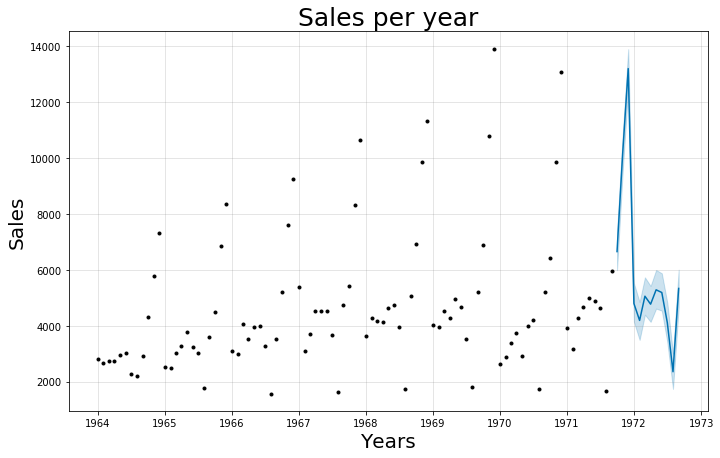

In [211]:
model.plot(output)
plt.xlabel('Years', fontsize = 20)
plt.ylabel('Sales', fontsize = 20)
plt.title('Sales per year', fontsize = 25)

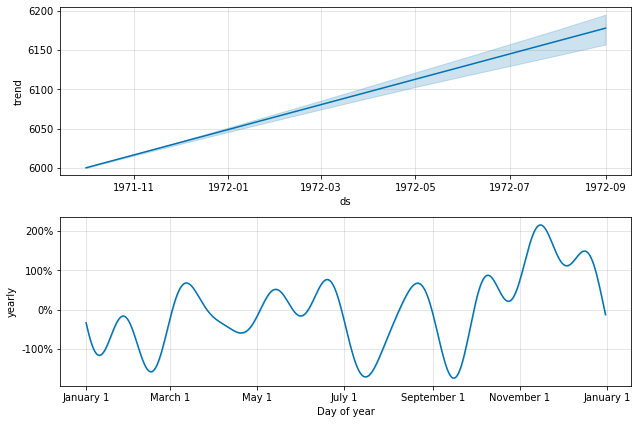

In [217]:
# The Prophet allow us to see the components as trend and seasonality

fig = model.plot_components(output)

# Conclusions

The Facebook Prophet comes to easily help us to make predictions with temporal series on Python and has some interesting features 
that can help us to improve our model.

This kind of predictions can be used to create a cronogram of consumables purchase, promotions, or even to prepare yourself to a seasonality sale time durant the year

To see more options to your own model, please have a look into the fbprophet github:
https://github.com/facebook/prophet/tree/master/python